# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.manifold import MDS, Isomap
import plotly.express as px
from IPython.core.debugger import set_trace
import plotly.io as pio
import plotly.graph_objects as go
from scipy.spatial.distance import squareform
from sklearn.linear_model import LinearRegression, Ridge
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
pio.renderers.default = 'iframe'
import json
import numpy as np, os, pdb
from scipy.stats import norm
from matplotlib.legend_handler import HandlerTuple

# Load human data

In [2]:
DOMAINS = ["color", "loudness", "pitch", "taste", "timbre", "vocal_consonant"]
TITLES = ["Colors", "Loudness", "Pitch", "Taste", "Timbre", "Consonants"]

all_human_data = {}

for dom in DOMAINS:
    all_human_data[dom] = {}
    all_human_data[dom]["similarity"] = np.load("human-data/" + dom + "_similarity.npy")
    all_human_data[dom]["labels"] = np.load("human-data/" + dom + "_labels.npy")
    

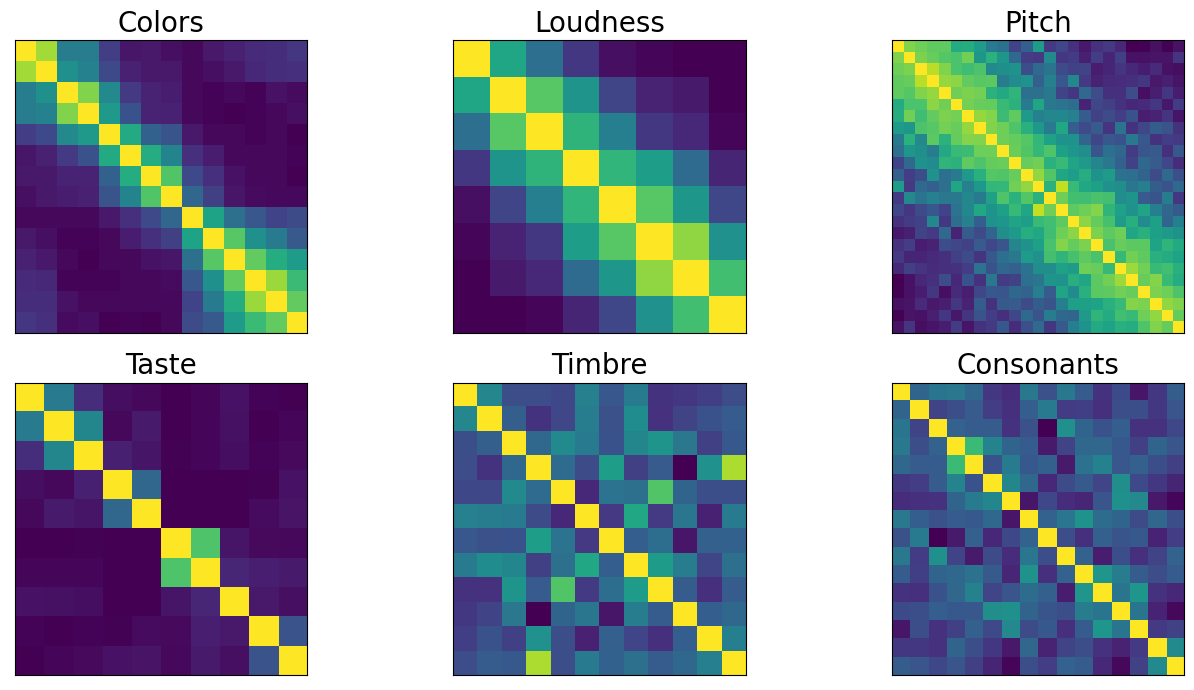

In [4]:
fig, ax = plt.subplots(2, 3, figsize = (14, 7)) # 12 8

counter = 0
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(all_human_data[DOMAINS[counter]]["similarity"])
        ax[i,j].set_title(TITLES[counter], fontsize = 20)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        counter += 1
        
fig.tight_layout()

# fig.savefig('figures/human_similarity_data_final.pdf', bbox_inches='tight')

# Load machine data

In [34]:
DATA_PATHS = [
    "color/more-colors-hex-3-text-davinci-003-0.7",
    "loudness/loudness-tone-3-text-davinci-003-0.7",
    "pitch/tones-extended-freq-3-text-davinci-003-0.7",
    "taste/taste-basic-3-text-davinci-003-0.7",
    "timbre/instruments-timbre-3-text-davinci-003-0.7",
    "vocal_consonant/vocal_consonant-newsims-3-text-davinci-003-0.7"
]

DATA_PATHS_GPT35 = [
    "color/more-colors-hex-3-gpt-35-turbo-0.7",
    "loudness/loudness-tone-3-gpt-35-turbo-0.7",
    "pitch/tones-extended-freq-3-gpt-35-turbo-0.7",
    "taste/taste-basic-3-gpt-35-turbo-0.7",
    "timbre/instruments-timbre-3-gpt-35-turbo-0.7",
    "vocal_consonant/vocal_consonant-newsims-3-gpt-35-turbo-0.7"
]

DATA_PATHS_GPT4 = [
    "color/more-colors-hex-3-gpt-4-0.7",
    "loudness/loudness-tone-3-gpt-4-0.7",
    "pitch/tones-extended-freq-3-gpt-4-0.7",
    "taste/taste-basic-3-gpt-4-0.7",
    "timbre/instruments-timbre-3-gpt-4-0.7",
    "vocal_consonant/vocal_consonant-newsims-3-gpt-4-0.7"
]

WHICH_MODEL = "gpt4" # gpt3 or gpt35 or gpt4
REPETITIONS = 10
all_machine_data = {}
for i, dom in enumerate(DOMAINS):
    sim_mat = 0
    for r in range(REPETITIONS):
        if WHICH_MODEL == "gpt3":
            sim_mat += np.load("gpt3-data/" + DATA_PATHS[i] + f"-{r + 1}.npy") / REPETITIONS
        elif WHICH_MODEL == "gpt35":
            sim_mat += np.load("gpt35-data/" + DATA_PATHS_GPT35[i] + f"-{r + 1}.npy") / REPETITIONS
        else:
            sim_mat += np.load("gpt4-data/" + DATA_PATHS_GPT4[i] + f"-{r + 1}.npy") / REPETITIONS
    if dom == "pitch":
        sim_mat = sim_mat[22:,22:]
    elif dom == "color":
        sim_mat = sim_mat[0:14,0:14]
    all_machine_data[dom] = {}
    all_machine_data[dom]["similarity"] = sim_mat
    all_machine_data[dom]["labels"] = np.load("human-data/" + dom + "_labels.npy")
    
    

In [35]:
# bootstrapping over machine data
NBOOT = 1000
all_machine_data_boots = {}
for i, dom in enumerate(DOMAINS):
    all_machine_data_boots[dom] = []
    for n in range(NBOOT):
        sim_mat = 0
        for r in range(REPETITIONS):
            if WHICH_MODEL == "gpt3":
                sim_mat += np.load("gpt3-data/" + DATA_PATHS[i] + f"-{np.random.randint(REPETITIONS) + 1}.npy") / REPETITIONS
            elif WHICH_MODEL == "gpt35":
                sim_mat += np.load("gpt35-data/" + DATA_PATHS_GPT35[i] + f"-{np.random.randint(REPETITIONS) + 1}.npy") / REPETITIONS
            else:
                sim_mat += np.load("gpt4-data/" + DATA_PATHS_GPT4[i] + f"-{np.random.randint(REPETITIONS) + 1}.npy") / REPETITIONS
        if dom == "pitch":
            sim_mat = sim_mat[22:,22:]
        elif dom == "color":
            sim_mat = sim_mat[0:14,0:14]
        all_machine_data_boots[dom].append(sim_mat)

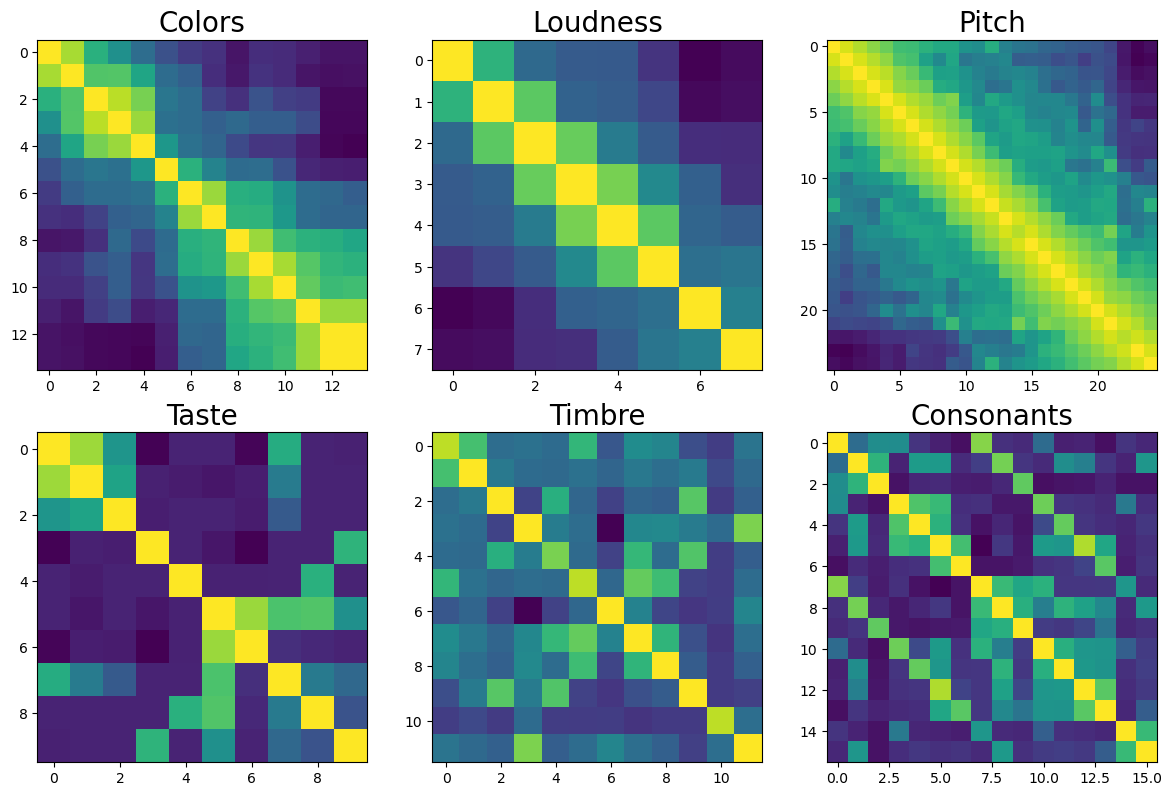

In [36]:
fig, ax = plt.subplots(2, 3, figsize = (12, 8))

counter = 0
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(all_machine_data[DOMAINS[counter]]["similarity"])
        ax[i,j].set_title(TITLES[counter], fontsize = 20)
        counter += 1
        
fig.tight_layout()

# fig.savefig('figures/machine_similarity_data_gpt4.pdf', bbox_inches='tight')

In [37]:
# np.save("all_model_simmats.npy", all_model_data, allow_pickle=True)

# Compare human and machine data

In [38]:
corr_vals = []
corr_sds = []
corr_raw = []
for dom in DOMAINS:
    vh = squareform(all_human_data[dom]["similarity"], checks = False)
    # vm = squareform(all_machine_data[dom]["similarity"], checks = False)
    vms = [squareform(mdat, checks = False) for mdat in all_machine_data_boots[dom]]
    boots_corrs = [np.corrcoef(vh, vm)[0][1] for vm in vms]
    corr_vals.append(np.mean(boots_corrs))
    corr_sds.append(np.std(boots_corrs))
    corr_raw.append(boots_corrs)

# all_corrs = {}
# all_corrs[WHICH_MODEL] = {}
# all_corrs[WHICH_MODEL]["vals"] = corr_vals.copy()
# all_corrs[WHICH_MODEL]["sds"] = corr_sds.copy()
# all_corrs[WHICH_MODEL]["raw"] = corr_raw.copy()

In [39]:
# np.save("all_model_correlations.npy", all_corrs, allow_pickle=True)

In [40]:
corr_vals = np.array(corr_vals)
corr_sds = np.array(corr_sds)
dnames = np.array(TITLES.copy())
arr1inds = corr_vals.argsort()
dnames = dnames[arr1inds]
corr_vals = corr_vals[arr1inds]
corr_sds = corr_sds[arr1inds]

Text(0, 0.5, 'Correlation (Pearson r)')

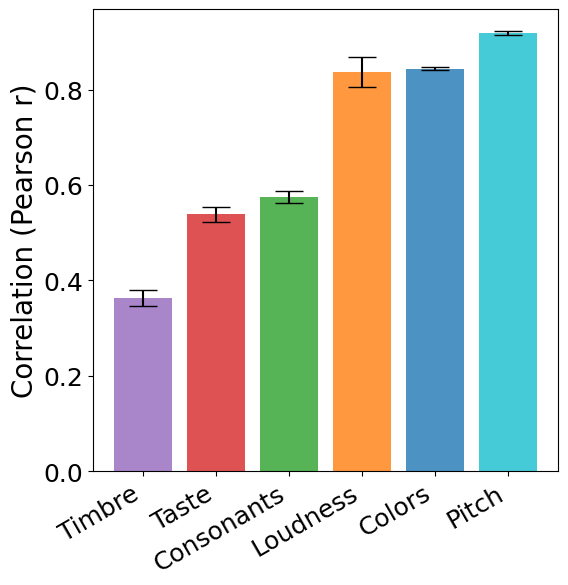

In [41]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
loc_vals = np.array([i for i in range(len(dnames))])
ax.bar(loc_vals, corr_vals, yerr = 1.96 * corr_sds, align='center', alpha=0.8, ecolor='black', capsize=10, color = ["tab:purple", "tab:red", "tab:green", "tab:orange", "tab:blue", "tab:cyan"])
ax.set_xticks(loc_vals)
ax.set_xticklabels(dnames, rotation=30, ha='right');
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel("Correlation (Pearson r)", fontsize = 20)

# Compute MDS

In [42]:
def compute_mds(dissimilarity, n_components=3, max_iter = 10000, eps = 1e-100, n_init = 50, verbose = 0, random_state = None):
    embedding = MDS(n_components=n_components, metric = True, dissimilarity = "precomputed", max_iter = max_iter, eps = eps, verbose = verbose, n_init = n_init, random_state = random_state)
    init = embedding.fit_transform(dissimilarity)
    embedding = MDS(n_components=n_components, metric = False, dissimilarity = "precomputed", max_iter = max_iter, eps = eps, verbose = verbose, random_state = random_state)
    transformed = embedding.fit_transform(dissimilarity, init = init)
    return transformed

def visualize_3d_mds(transformed, annotations, show_grid = True):
    X = transformed[:,0]
    Y = transformed[:,1]
    Z = transformed[:,2]

    tX1 = [X[2*i] for i in range(13)]
    tY1 = [Y[2*i] for i in range(13)]
    tZ1 = [Z[2*i] for i in range(13)]
    df1 = pd.DataFrame({"X": tX1, "Y": tY1, "Z": tZ1})

    tX2 = [X[2*i + 1] for i in range(12)]
    tY2 = [Y[2*i + 1] for i in range(12)]
    tZ2 = [Z[2*i + 1] for i in range(12)]
    df2 = pd.DataFrame({"X": tX2, "Y": tY2, "Z": tZ2})

    df = pd.DataFrame({"X": X, "Y": Y, "Z": Z, "cat": annotations, "val": [json.loads(el) for el in annotations]})
    fig = px.scatter_3d(df, x='X', y='Y', z='Z', color='val', text="cat", color_continuous_scale="viridis", width=800, height=800)

    fig_line = px.line_3d(df, x='X', y='Y', z='Z', width=800, height=800)
    # fig_line1 = px.line_3d(df1, x='X', y='Y', z='Z', width=800, height=800)
    # fig_line2 = px.line_3d(df2, x='X', y='Y', z='Z', width=800, height=800)
    fig = go.Figure(data = fig.data + fig_line.data)

    fig.update_traces(showlegend=False)
    if show_grid:
        fig.update_layout(scene = dict(
            xaxis = dict(
                backgroundcolor="rgba(0, 0, 0, 0)",
                gridcolor="lightgrey",
                showbackground=True,
                zerolinecolor="black",),
                yaxis = dict(
                    backgroundcolor="rgba(0, 0, 0, 0)",
                    gridcolor="lightgrey",
                    showbackground=True,
                    zerolinecolor="black"),
                zaxis = dict(
                    backgroundcolor="rgba(0, 0, 0, 0)",
                    gridcolor="lightgrey",
                    showbackground=True,
                    zerolinecolor="black",),),
                )
    else:
        fig.update_layout(scene = dict(
            xaxis = dict(
                backgroundcolor="rgba(0, 0, 0, 0)",
                gridcolor="rgba(0, 0, 0, 0)",
                showbackground=True,
                zerolinecolor="rgba(0, 0, 0, 0)",),
                yaxis = dict(
                    backgroundcolor="rgba(0, 0, 0, 0)",
                    gridcolor="rgba(0, 0, 0, 0)",
                    showbackground=True,
                    zerolinecolor="rgba(0, 0, 0, 0)"),
                zaxis = dict(
                    backgroundcolor="rgba(0, 0, 0, 0)",
                    gridcolor="rgba(0, 0, 0, 0)",
                    showbackground=True,
                    zerolinecolor="rgba(0, 0, 0, 0)",),),
                )
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=0.8/2, y=4/2, z=2/2)
    )
    fig.update_layout(
        height=800,
        width=800,
        scene_camera=camera,
        # margin=dict(t=0, r=4, l=0, b=0)
    )

    fig.update_traces(marker_size = 10, line = dict(color='royalblue', width=4, dash='dot'))
        
    fig.update_layout(coloraxis_colorbar=dict(
        title="Pitch",
        thicknessmode="pixels", thickness=30,
        lenmode="pixels", len=200,
        tickfont=dict(size=15),
    ))
    fig.update_coloraxes(colorscale="Viridis")
    fig.update_layout(scene=dict(xaxis=dict(range=[-0.7, 0.7]), yaxis=dict(range=[-0.7, 0.7]), zaxis=dict(range=[-0.7, 0.7])))
    
    return fig

def freq2midi(f):
    return 12 * np.log2(f / 440) + 69

def compute_diagonal_marginals(dmat):
    return [np.mean(np.diag(dmat,k=s)) for s in range(1,dmat.shape[0])]

## Pitch

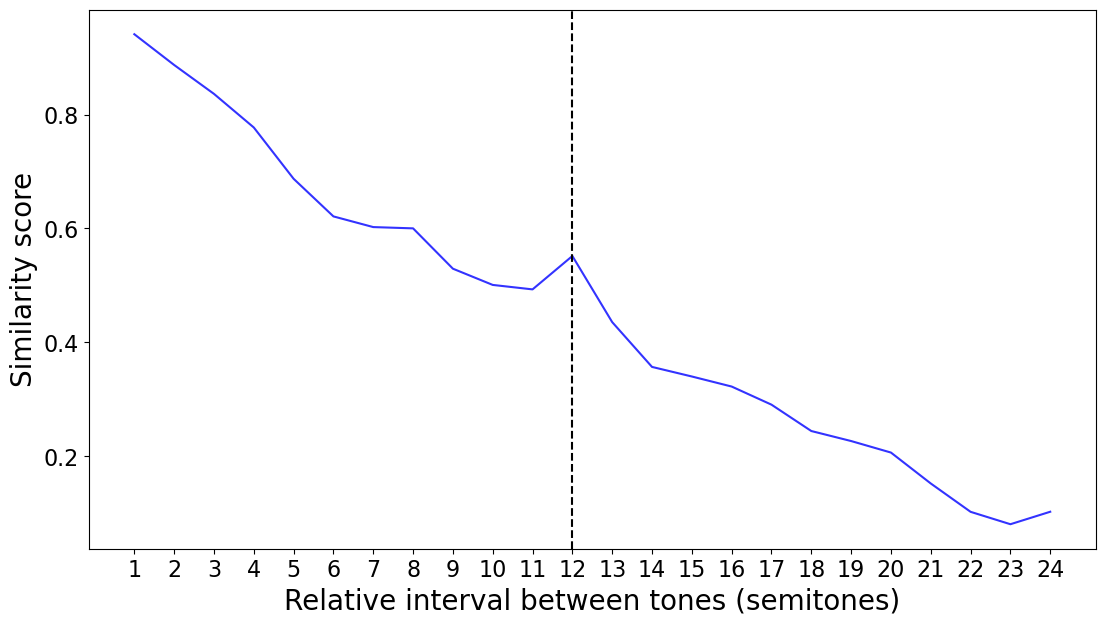

In [43]:
current_machine_data = all_machine_data["pitch"]["similarity"]
current_human_data = all_human_data["pitch"]["similarity"]
fig, ax = plt.subplots(1, 1, figsize = (13, 7))
labels = [i for i in range(1, current_human_data.shape[0])]
ax.plot(labels, compute_diagonal_marginals(current_machine_data), color = "blue", alpha = 0.8, label = "GPT3")
ax.axvline(x = 12, color = 'black', ls = "--")
# ax.plot(labels, compute_diagonal_marginals(current_human_data), color = "red", alpha = 0.8, label = "Human")
ax.set_xticks(labels);
# ax.legend(fontsize = 20)
ax.set_xlabel("Relative interval between tones (semitones)", fontsize = 20)
ax.set_ylabel("Similarity score", fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('figures/pitch_gpt3_marginal_v2.pdf', bbox_inches='tight')

In [44]:
# all_marginals = {}
# all_marginals[WHICH_MODEL] = compute_diagonal_marginals(current_machine_data)

In [45]:
# np.save("all_pitch_marginals.npy", all_marginals, allow_pickle=True)

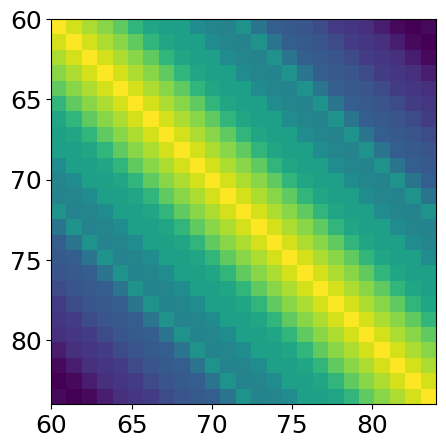

In [46]:
averaged_matrix = np.zeros(all_machine_data["pitch"]["similarity"].shape)
p_vals = [int(p) for p in all_machine_data["pitch"]["labels"]]
marginal_vals = [1] + list(compute_diagonal_marginals(current_machine_data))
for i in range(averaged_matrix.shape[0]):
    for j in range(averaged_matrix.shape[1]):
        averaged_matrix[i,j] = marginal_vals[int(abs(p_vals[i] - p_vals[j]))]
    
# plt.imshow(averaged_matrix)
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(averaged_matrix, extent=[int(min(p_vals)), int(max(p_vals)), int(max(p_vals)), int(min(p_vals))]);
ax.tick_params(axis='both', which='major', labelsize=18)
# fig.savefig('figures/pitch_gpt3_similarity_smoothed.pdf', bbox_inches='tight')

In [47]:
list_of_pitch = all_machine_data["pitch"]["labels"]
mds_vecs = compute_mds(1 - averaged_matrix, random_state = 89) # 89
fig = visualize_3d_mds(mds_vecs, list_of_pitch, show_grid = False)
fig.show()

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:318: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 4



In [48]:
# fig.write_image("figures/gpt3_spiral_perspective_1.pdf")

## Colors

In [49]:
# Load extended color data for enhanced visualization
if WHICH_MODEL == "gpt3":
    dpath = "color/more-colors-hex-3-text-davinci-003-0.7"
elif WHICH_MODEL == "gpt35":
    dpath = "color/more-colors-hex-3-gpt-35-turbo-0.7"
else:
    dpath = "color/more-colors-hex-3-gpt-4-0.7"
# data = np.delete(data,14,0)
# data = np.delete(data,14,1)
extened_color_sim = 0
for r in range(REPETITIONS):
    if WHICH_MODEL == "gpt3":
        extened_color_sim += np.load("gpt3-data/" + dpath + f"-{r + 1}.npy") / REPETITIONS
    elif WHICH_MODEL == "gpt35":
        extened_color_sim += np.load("gpt35-data/" + dpath + f"-{r + 1}.npy") / REPETITIONS
    else:
        extened_color_sim += np.load("gpt4-data/" + dpath + f"-{r + 1}.npy") / REPETITIONS

extened_color_sim = np.delete(extened_color_sim,14,0) # remove black
extened_color_sim = np.delete(extened_color_sim,14,1) # remove black
extended_color_labels = np.load("color_labels_extended.npy")
extended_color_labels = np.delete(extended_color_labels,14,0)
mds_vecs = compute_mds(1 - extened_color_sim, n_components = 2, random_state = 4) #4

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:318: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 4



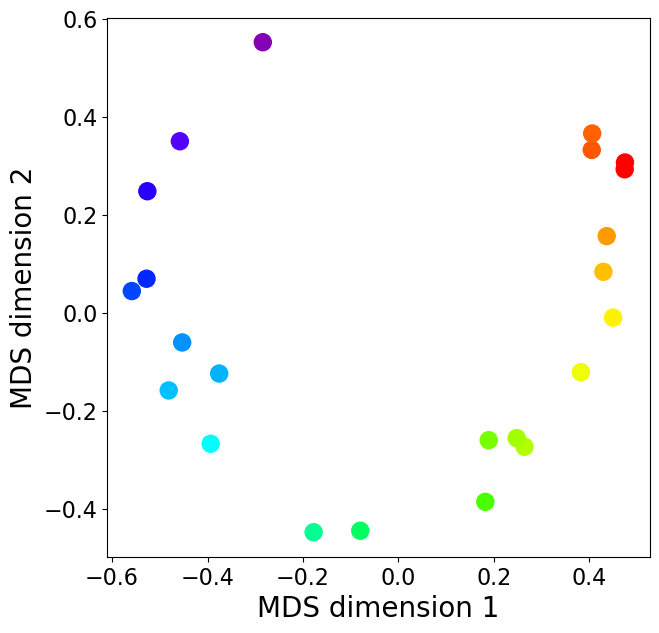

In [50]:
X = mds_vecs[:,0]
Y = mds_vecs[:,1]
fig, ax = plt.subplots(1, 1, figsize = (7,7))
ax.scatter(X,Y,color = extended_color_labels, s=150)
ax.set_xlabel("MDS dimension 1", fontsize = 20);
ax.set_ylabel("MDS dimension 2", fontsize = 20);
ax.tick_params(axis='both', which='major', labelsize=16)
# fig.savefig('figures/colors_gpt4_extended_mds_final.pdf', bbox_inches='tight')

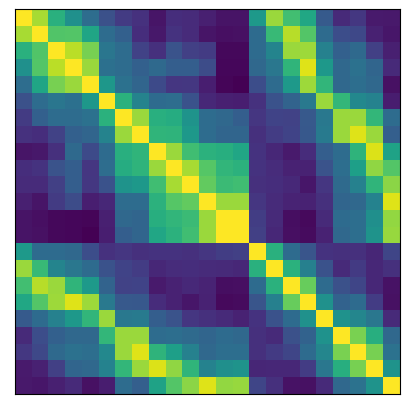

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.imshow(extened_color_sim);
ax.set_xticks([]);
ax.set_yticks([]);
# fig.savefig('figures/colors_gpt3_extended_similarity.pdf', bbox_inches='tight')

## Vocal consonants

In [52]:
con_h = all_human_data["vocal_consonant"]
con_m = all_machine_data["vocal_consonant"]

con_mds_h = compute_mds(1 - con_h["similarity"], n_components = 2, random_state = 19)
con_mds_m = compute_mds(1 - con_m["similarity"], n_components = 2, random_state = 19)

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:318: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 4

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalize

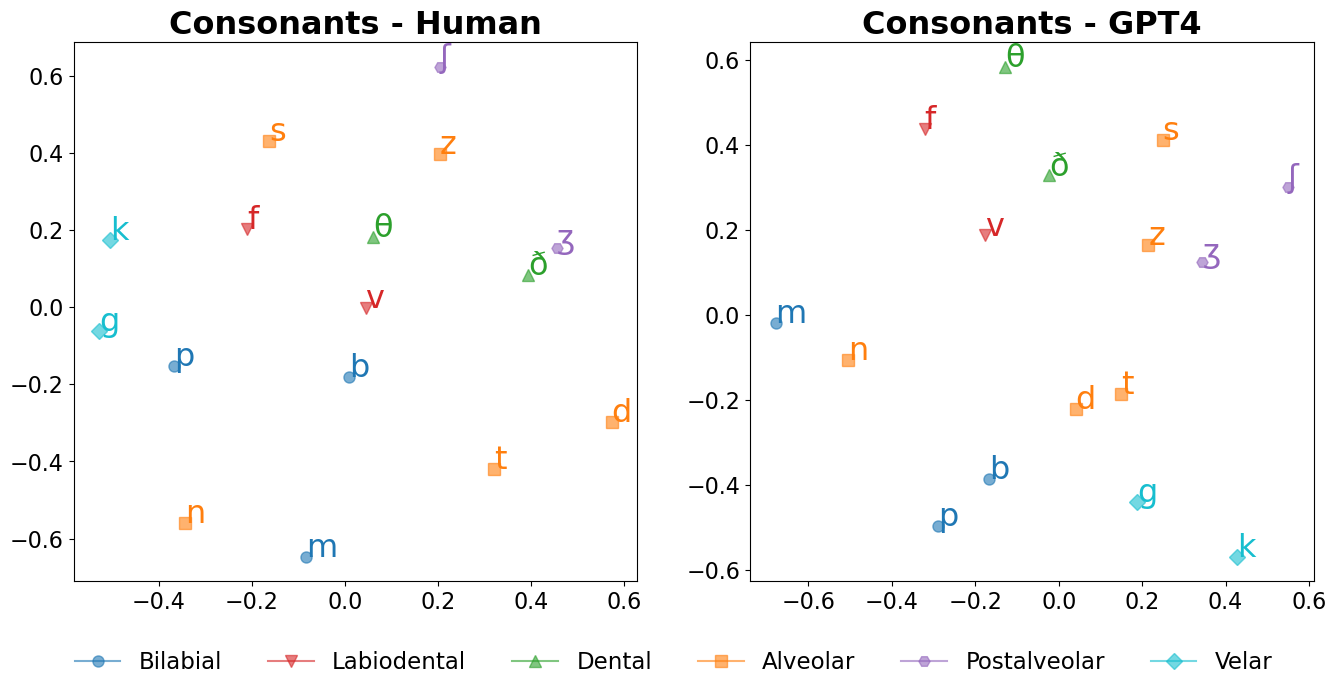

In [53]:
place_of_articulation = [
    "Bilabial",
    "Alveolar",
    "Velar",
    "Labiodental",
    "Dental",
    "Alveolar",
    "Postalveolar",
    "Bilabial",
    "Alveolar",
    "Velar",
    "Labiodental",
    "Dental",
    "Alveolar",
    "Postalveolar",
    "Bilabial",
    "Alveolar"
]


color_map = {
    "Bilabial": "tab:blue",
    "Labiodental": "tab:red",
    "Dental": "tab:green",
    "Alveolar": "tab:orange",
    "Postalveolar": "tab:purple",
    "Velar": "tab:cyan"
}

marker_map = {
    "Bilabial": "o",
    "Labiodental": "v",
    "Dental": "^",
    "Alveolar": "s",
    "Postalveolar": "H",
    "Velar": "D"
}

color_vec = [color_map[s] for s in place_of_articulation]
marker_vec = [marker_map[s] for s in place_of_articulation]
eps = 0
fig, ax = plt.subplots(1, 2, figsize = (16, 7))
ppts = []
for i in range(len(place_of_articulation)):
    pp, = ax[0].plot(con_mds_h[i,0], con_mds_h[i,1], alpha = 0.6, c = color_vec[i], marker = marker_vec[i], markersize=8)
    ppts.append(pp)
    ax[0].annotate(con_h["labels"][i], (con_mds_h[i,0]+eps, con_mds_h[i,1]+eps), c = color_vec[i], fontsize = 23)
ax[0].set_title("Consonants - Human", fontsize = 23, fontweight="bold");
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(len(place_of_articulation)):
    ax[1].plot(con_mds_m[i,0], con_mds_m[i,1], alpha = 0.6, c = color_vec[i], marker = marker_vec[i], markersize=8)
    ax[1].annotate(con_m["labels"][i], (con_mds_m[i,0]+eps, con_mds_m[i,1]+eps), c = color_vec[i], fontsize = 23)
ax[1].set_title("Consonants - GPT4", fontsize = 23, fontweight="bold");
ax[1].tick_params(axis='both', which='major', labelsize=16)

fig.legend([ppts[0], ppts[3], ppts[4], ppts[1], ppts[6], ppts[2]],
           ['Bilabial', "Labiodental", "Dental", "Alveolar", "Postalveolar", "Velar"],
           loc='upper center', bbox_to_anchor=(0.5, 0.04), ncol=6, fancybox=True, fontsize = 16.5, frameon=False)

# fig.savefig('figures/vocal_consonants_comparison_mds_v5_gpt4.pdf', bbox_inches='tight')

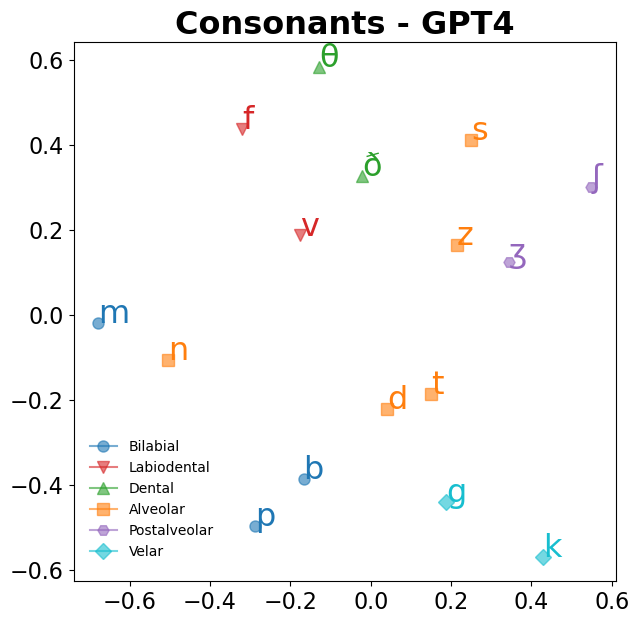

In [54]:
color_vec = [color_map[s] for s in place_of_articulation]
marker_vec = [marker_map[s] for s in place_of_articulation]
eps = 0
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
ppts = []

for i in range(len(place_of_articulation)):
    pp, = ax.plot(con_mds_m[i,0], con_mds_m[i,1], alpha = 0.6, c = color_vec[i], marker = marker_vec[i], markersize=8)
    ppts.append(pp)
    ax.annotate(con_m["labels"][i], (con_mds_m[i,0]+eps, con_mds_m[i,1]+eps), c = color_vec[i], fontsize = 23)
ax.set_title("Consonants - GPT4", fontsize = 23, fontweight="bold");
ax.tick_params(axis='both', which='major', labelsize=16)

fig.legend([ppts[0], ppts[3], ppts[4], ppts[1], ppts[6], ppts[2]],
           ['Bilabial', "Labiodental", "Dental", "Alveolar", "Postalveolar", "Velar"],
           loc='upper left', bbox_to_anchor=(0.13, 0.33), frameon=False)


# plt.savefig("figures/GPT4_consonants_MDS.pdf")

## Other domains

In [55]:
OTHER_DOMAINS = ["loudness", "taste", "timbre"]
OTHER_TITLES = ["Loudness", "Taste", "Timbre"]
MDS_info_h = {}
MDS_info_m = {}

for dom in OTHER_DOMAINS:
    current_sim = all_human_data[dom]["similarity"]
    MDS_info_h[dom] = {}
    # if dom == "vocal_consonant":
    #     rs = 19
    # else:
    #     rs = 432
    MDS_info_h[dom]["vectors"] = compute_mds(1 - current_sim, n_components = 2, random_state = 432) # 554
    MDS_info_h[dom]["labels"] = all_human_data[dom]["labels"]
    
for dom in OTHER_DOMAINS:
    current_sim = all_machine_data[dom]["similarity"]
    MDS_info_m[dom] = {}
    # if dom == "vocal_consonant":
    #     rs = 19
    # else:
    #     rs = 432
    MDS_info_m[dom]["vectors"] = compute_mds(1 - current_sim, n_components = 2, random_state = 432) # 554
    MDS_info_m[dom]["labels"] = all_machine_data[dom]["labels"]

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:318: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 4

/Users/rajamarjieh/opt/anaconda3/envs/mds/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalize

In [56]:
# np.save("human_MDS.npy", MDS_info_h)

In [57]:
# Color scheme

OTHER_DOMAIN_COLORS = {}
OTHER_DOMAIN_COLORS["loudness"] = {}
OTHER_DOMAIN_COLORS["taste"] = {}
OTHER_DOMAIN_COLORS["timbre"] = {}

OTHER_DOMAIN_COLORS["loudness"] = [float(ll) for ll in MDS_info_h["loudness"]["labels"]]
# for label in MDS_info_h["loudness"]["labels"]:
#     OTHER_DOMAIN_COLORS["loudness"][label] = float(label)

OTHER_DOMAIN_COLORS["taste"]["salt"] = "tab:blue"
OTHER_DOMAIN_COLORS["taste"]["salt substitute"] = "tab:blue"
OTHER_DOMAIN_COLORS["taste"]["MSG"] = "tab:blue"
OTHER_DOMAIN_COLORS["taste"]["sugar"] = "tab:red"
OTHER_DOMAIN_COLORS["taste"]["quinine"] = "tab:green"
OTHER_DOMAIN_COLORS["taste"]["acid"] = "tab:orange"
OTHER_DOMAIN_COLORS["taste"]["salt-sugar"] = ["tab:blue", "tab:red"]
OTHER_DOMAIN_COLORS["taste"]["quinine-sugar"] = ["tab:green", "tab:red"]
OTHER_DOMAIN_COLORS["taste"]["acid-sugar"] = ["tab:orange", "tab:red"]
OTHER_DOMAIN_COLORS["taste"]["artificial sweetener"] = "tab:red"

OTHER_DOMAIN_COLORS["timbre"]["Clarinet"] = "tab:blue"
OTHER_DOMAIN_COLORS["timbre"]["Saxophone"] = "tab:blue"
OTHER_DOMAIN_COLORS["timbre"]["Trumpet"] = "tab:orange"
OTHER_DOMAIN_COLORS["timbre"]["Cello"] = "tab:red"
OTHER_DOMAIN_COLORS["timbre"]["FrenchHorn"] = "tab:orange"
OTHER_DOMAIN_COLORS["timbre"]["Oboe"] = "tab:blue"
OTHER_DOMAIN_COLORS["timbre"]["Flute"] = "tab:blue"
OTHER_DOMAIN_COLORS["timbre"]["EnglishHorn"] = "tab:blue"
OTHER_DOMAIN_COLORS["timbre"]["Bassoon"] = "tab:blue"
OTHER_DOMAIN_COLORS["timbre"]["Trombone"] = "tab:orange"
OTHER_DOMAIN_COLORS["timbre"]["Piano"] = "tab:green"
OTHER_DOMAIN_COLORS["timbre"]["Violin"] = "tab:red"

# Abbreviation scheme

OTHER_DOMAIN_ABBRV = {}
OTHER_DOMAIN_ABBRV["loudness"] = {}
OTHER_DOMAIN_ABBRV["taste"] = {}
OTHER_DOMAIN_ABBRV["timbre"] = {}

for label in MDS_info_h["loudness"]["labels"]:
    OTHER_DOMAIN_ABBRV["loudness"][label] = label

OTHER_DOMAIN_ABBRV["taste"]["salt"] = "SLT"
OTHER_DOMAIN_ABBRV["taste"]["salt substitute"] = "SLTS"
OTHER_DOMAIN_ABBRV["taste"]["MSG"] = "MSG"
OTHER_DOMAIN_ABBRV["taste"]["sugar"] = "SUG"
OTHER_DOMAIN_ABBRV["taste"]["quinine"] = "QUI"
OTHER_DOMAIN_ABBRV["taste"]["acid"] = "ACD"
OTHER_DOMAIN_ABBRV["taste"]["salt-sugar"] = "SLT-SUG"
OTHER_DOMAIN_ABBRV["taste"]["quinine-sugar"] = "QUI-SUG"
OTHER_DOMAIN_ABBRV["taste"]["acid-sugar"] = "ACD-SUG"
OTHER_DOMAIN_ABBRV["taste"]["artificial sweetener"] = "AS"

OTHER_DOMAIN_ABBRV["timbre"]["Clarinet"] = "CL"
OTHER_DOMAIN_ABBRV["timbre"]["Saxophone"] = "SX"
OTHER_DOMAIN_ABBRV["timbre"]["Trumpet"] = "TP"
OTHER_DOMAIN_ABBRV["timbre"]["Cello"] = "C"
OTHER_DOMAIN_ABBRV["timbre"]["FrenchHorn"] = "FH"
OTHER_DOMAIN_ABBRV["timbre"]["Oboe"] = "OB"
OTHER_DOMAIN_ABBRV["timbre"]["Flute"] = "FL"
OTHER_DOMAIN_ABBRV["timbre"]["EnglishHorn"] = "EH"
OTHER_DOMAIN_ABBRV["timbre"]["Bassoon"] = "BS"
OTHER_DOMAIN_ABBRV["timbre"]["Trombone"] = "TB"
OTHER_DOMAIN_ABBRV["timbre"]["Piano"] = "P"
OTHER_DOMAIN_ABBRV["timbre"]["Violin"] = "V"    

In [58]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

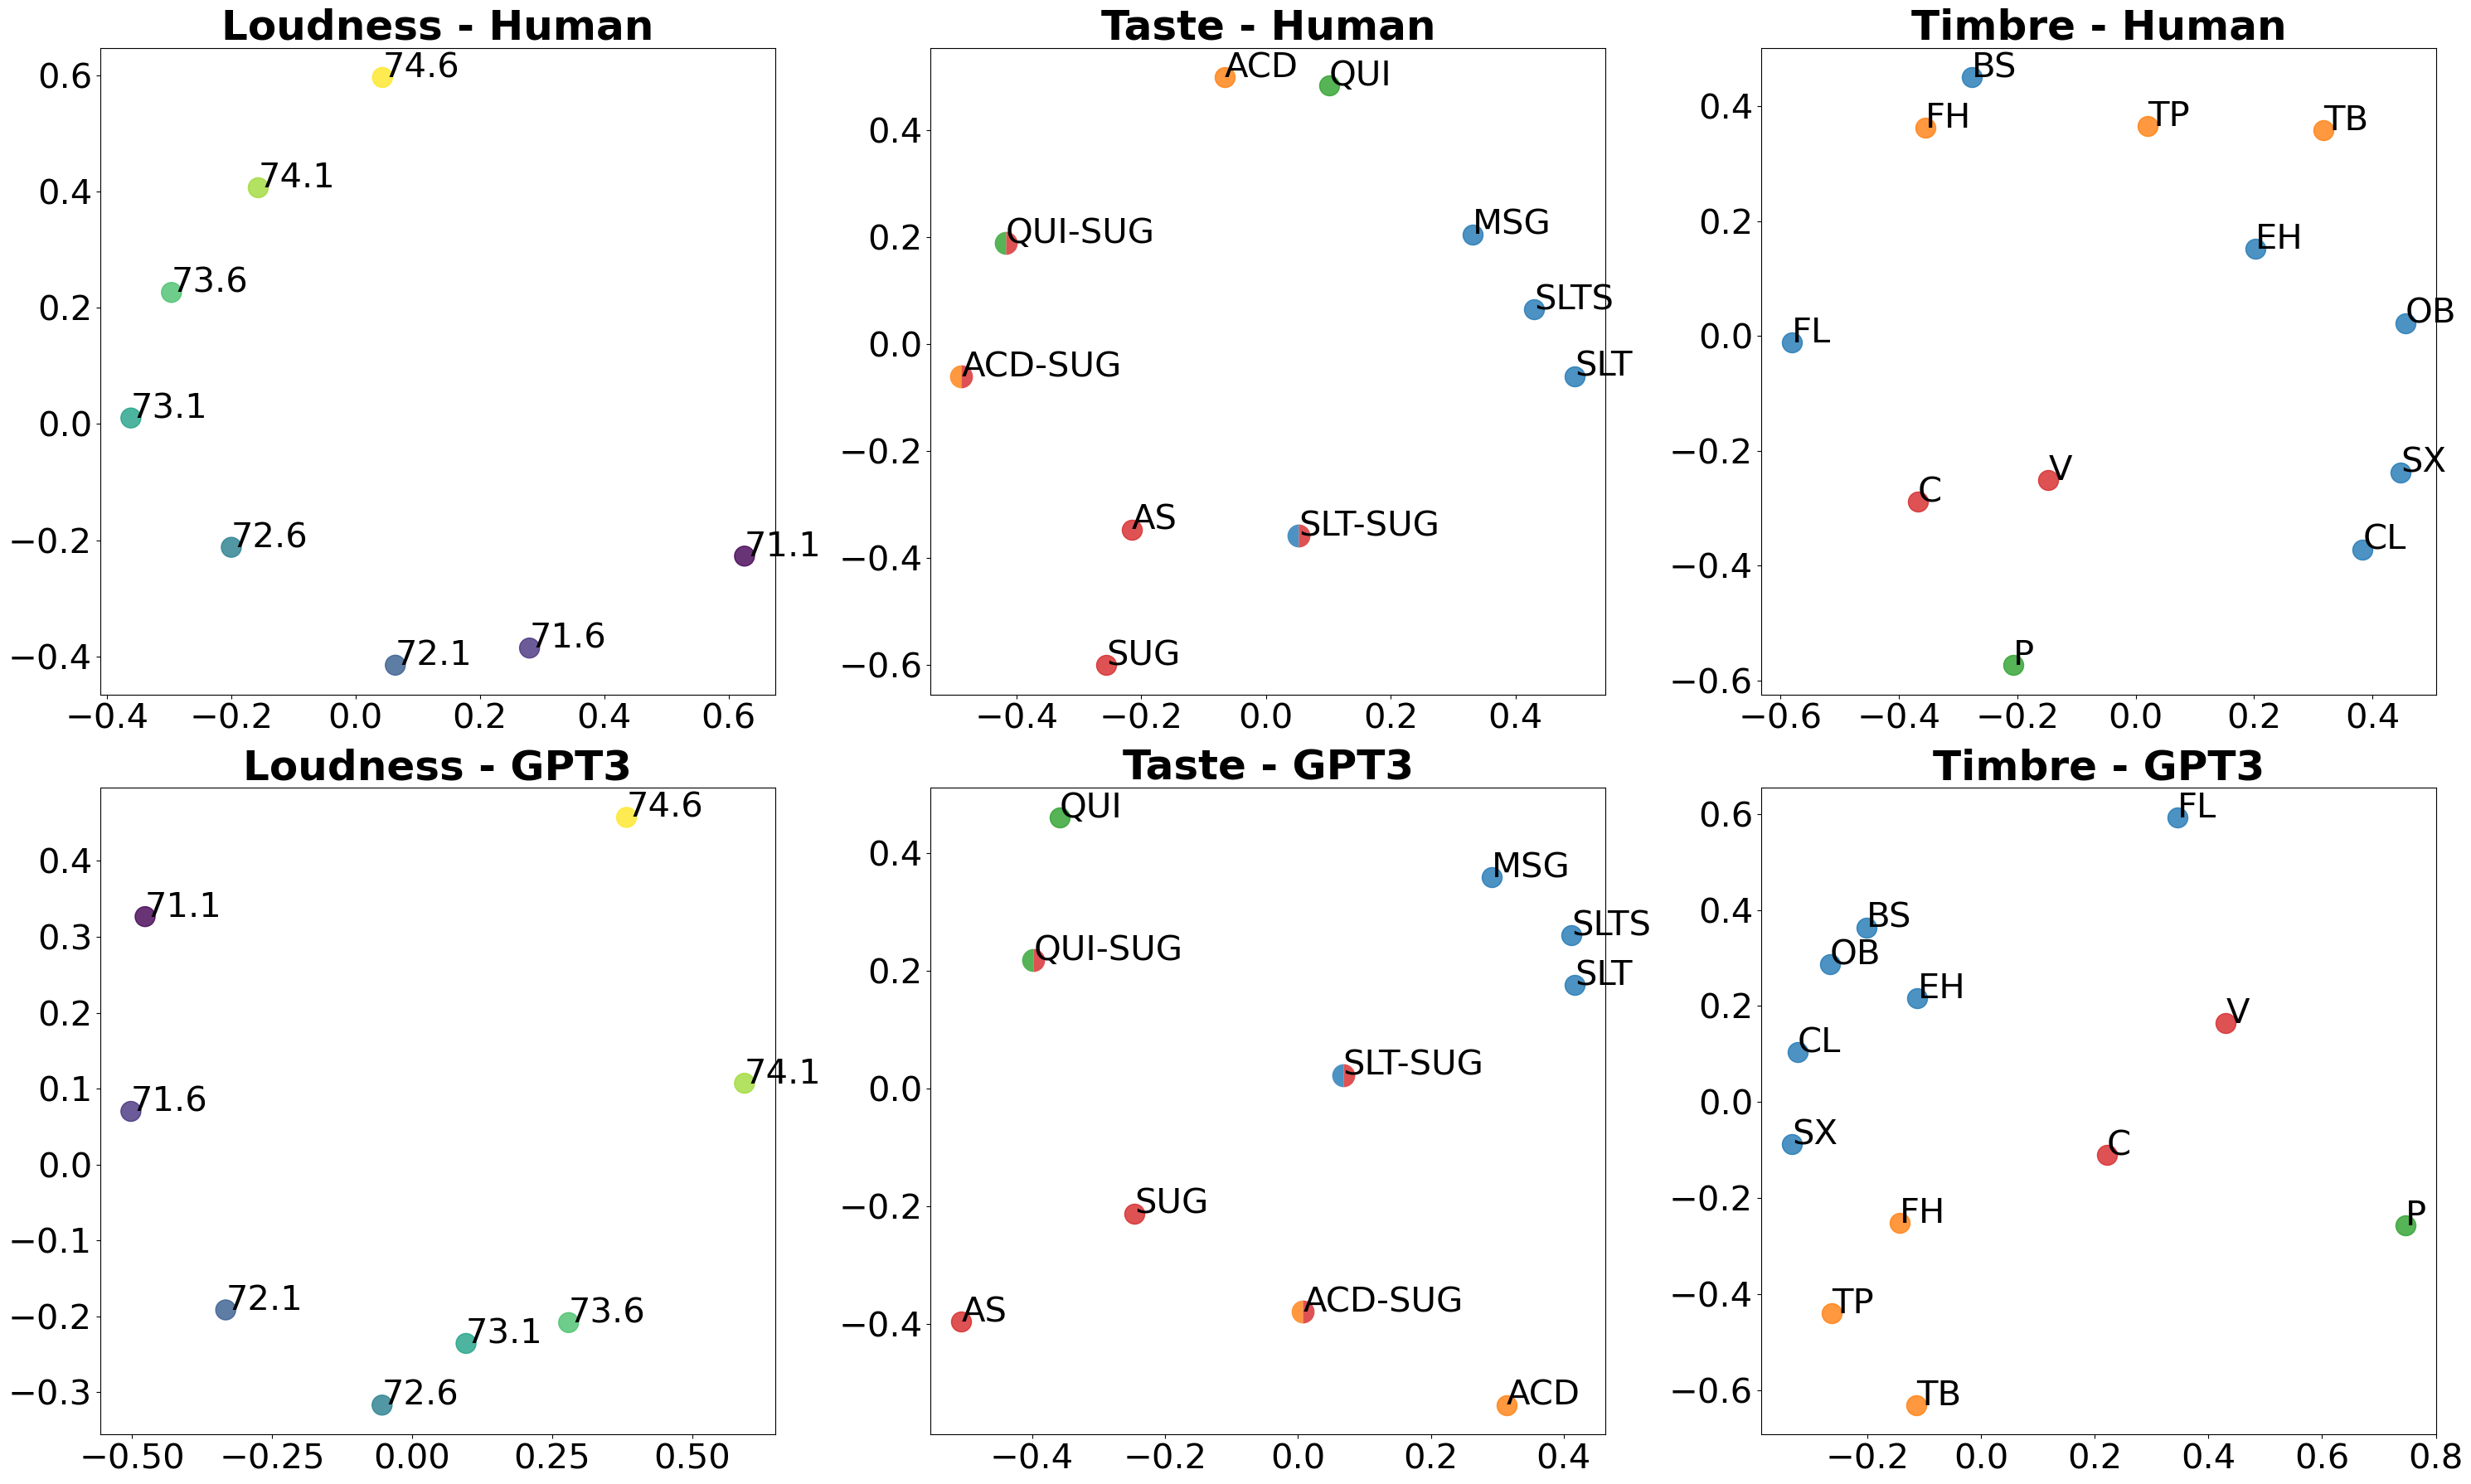

In [59]:
fig, ax = plt.subplots(2, 3, figsize = (30, 18))

counter = 0
for i in [0]:
    for j in range(3):
        current_domain = OTHER_DOMAINS[counter]
        X = MDS_info_h[current_domain]["vectors"][:,0]
        Y = MDS_info_h[current_domain]["vectors"][:,1]
        # ax[i,j].scatter(X, Y, alpha = 0.4)
        ax[i,j].set_title(OTHER_TITLES[counter] + " - Human", fontsize = 36, fontweight="bold");
        ax[i,j].tick_params(axis='both', which='major', labelsize=30)
        if current_domain == "loudness":
            ax[i,j].scatter(X, Y, alpha = 0.8, c = OTHER_DOMAIN_COLORS[current_domain], s = 300, cmap = "viridis")
            for k, txt in enumerate(MDS_info_h[current_domain]["labels"]):
                ax[i,j].annotate(OTHER_DOMAIN_ABBRV[current_domain][txt], (X[k], Y[k]), fontsize = 30)           
        else:
            for k, txt in enumerate(MDS_info_h[current_domain]["labels"]):
                if txt not in ["quinine-sugar", "salt-sugar", "acid-sugar"]:
                    ax[i,j].scatter(X[k], Y[k], alpha = 0.8, color = OTHER_DOMAIN_COLORS[current_domain][txt], s = 300)
                else:
                    ax[i,j].plot(X[k], Y[k], alpha = 0.8, 
                                    c = OTHER_DOMAIN_COLORS[current_domain][txt][0],
                                    markerfacecoloralt=OTHER_DOMAIN_COLORS[current_domain][txt][1],
                                    marker='.', linestyle='', markeredgecolor='None',
                                    markersize=40, fillstyle='left', markeredgewidth=0)
                ax[i,j].annotate(OTHER_DOMAIN_ABBRV[current_domain][txt], (X[k], Y[k]), fontsize = 30)      
        counter += 1

counter = 0
for i in [1]:
    for j in range(3):
        current_domain = OTHER_DOMAINS[counter]
        X = MDS_info_m[current_domain]["vectors"][:,0]
        Y = MDS_info_m[current_domain]["vectors"][:,1]
        # ax[i,j].scatter(X, Y, alpha = 0.4)
        ax[i,j].set_title(OTHER_TITLES[counter] + " - GPT3", fontsize = 36, fontweight="bold");
        ax[i,j].tick_params(axis='both', which='major', labelsize=30)
        if current_domain == "loudness":
            ax[i,j].scatter(X, Y, alpha = 0.8, c = OTHER_DOMAIN_COLORS[current_domain], s = 300, cmap = "viridis")
            for k, txt in enumerate(MDS_info_h[current_domain]["labels"]):
                ax[i,j].annotate(OTHER_DOMAIN_ABBRV[current_domain][txt], (X[k], Y[k]), fontsize = 30)           
        else:
            for k, txt in enumerate(MDS_info_h[current_domain]["labels"]):
                if txt not in ["quinine-sugar", "salt-sugar", "acid-sugar"]:
                    ax[i,j].scatter(X[k], Y[k], alpha = 0.8, color = OTHER_DOMAIN_COLORS[current_domain][txt], s = 300)
                else:
                    ax[i,j].plot(X[k], Y[k], alpha = 0.8, 
                                    c = OTHER_DOMAIN_COLORS[current_domain][txt][0],
                                    markerfacecoloralt=OTHER_DOMAIN_COLORS[current_domain][txt][1],
                                    marker='.', linestyle='', markeredgecolor='None',
                                    markersize=40, fillstyle='left', markeredgewidth=0)
                ax[i,j].annotate(OTHER_DOMAIN_ABBRV[current_domain][txt], (X[k], Y[k]), fontsize = 30)    
        counter += 1
        
fig.tight_layout()

# fig.savefig('figures/other_domains_mds_final_v4.pdf', bbox_inches='tight')

# Combined bar plot across models

In [60]:
corrs = np.load("all_model_correlations.npy", allow_pickle=True)
corrs = corrs.item()

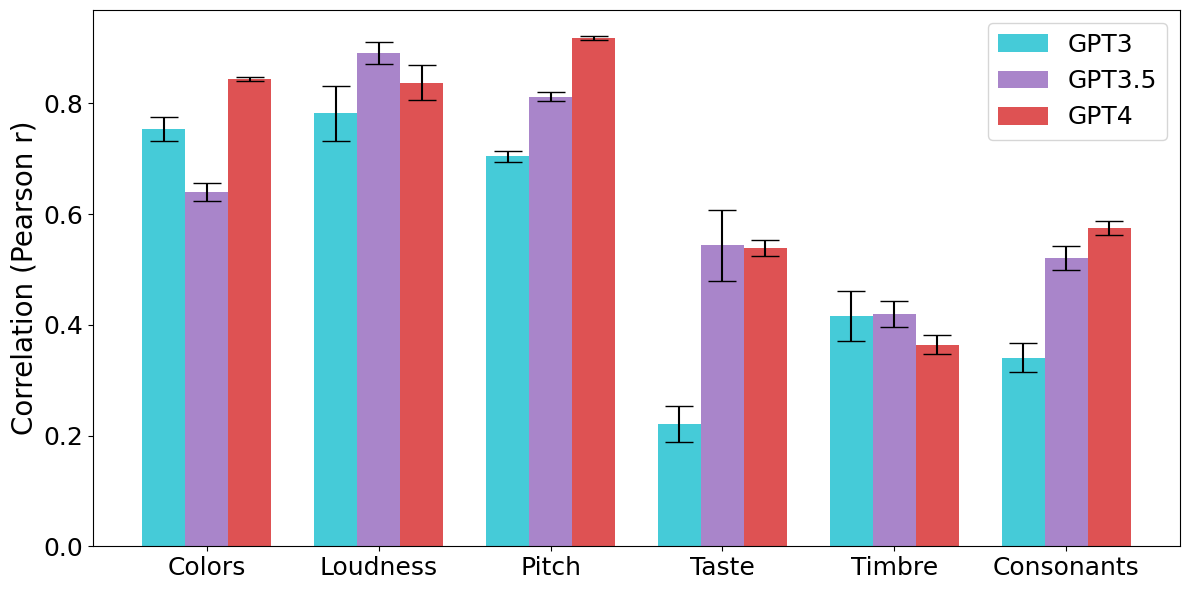

In [61]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
loc_vals = np.array([i for i in range(len(DOMAINS))])
width = 0.25

ax.bar(loc_vals - width, corrs["gpt3"]["vals"], yerr = 1.96 * np.array(corrs["gpt3"]["sds"]), align='center', alpha=0.8, ecolor='black', capsize=10, color = "tab:cyan", label="GPT3", width=width)
ax.bar(loc_vals, corrs["gpt35"]["vals"], yerr = 1.96 * np.array(corrs["gpt35"]["sds"]), align='center', alpha=0.8, ecolor='black', capsize=10, color = "tab:purple", label="GPT3.5", width=width)
ax.bar(loc_vals + width, corrs["gpt4"]["vals"], yerr = 1.96 * np.array(corrs["gpt4"]["sds"]), align='center', alpha=0.8, ecolor='black', capsize=10, color = "tab:red", label="GPT4", width=width)


ax.set_xticks(loc_vals)
ax.legend(fontsize=18)
# ax.set_xticklabels(TITLES, rotation=30, ha='right');
ax.set_xticklabels(TITLES);
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel("Correlation (Pearson r)", fontsize = 20)
plt.tight_layout()
# plt.savefig("figures/all_model_and_domain_correlations.pdf")

# Pitch marginals

In [63]:
all_marginals_pitch = np.load("all_pitch_marginals.npy", allow_pickle=True)
all_marginals_pitch = all_marginals_pitch.item()

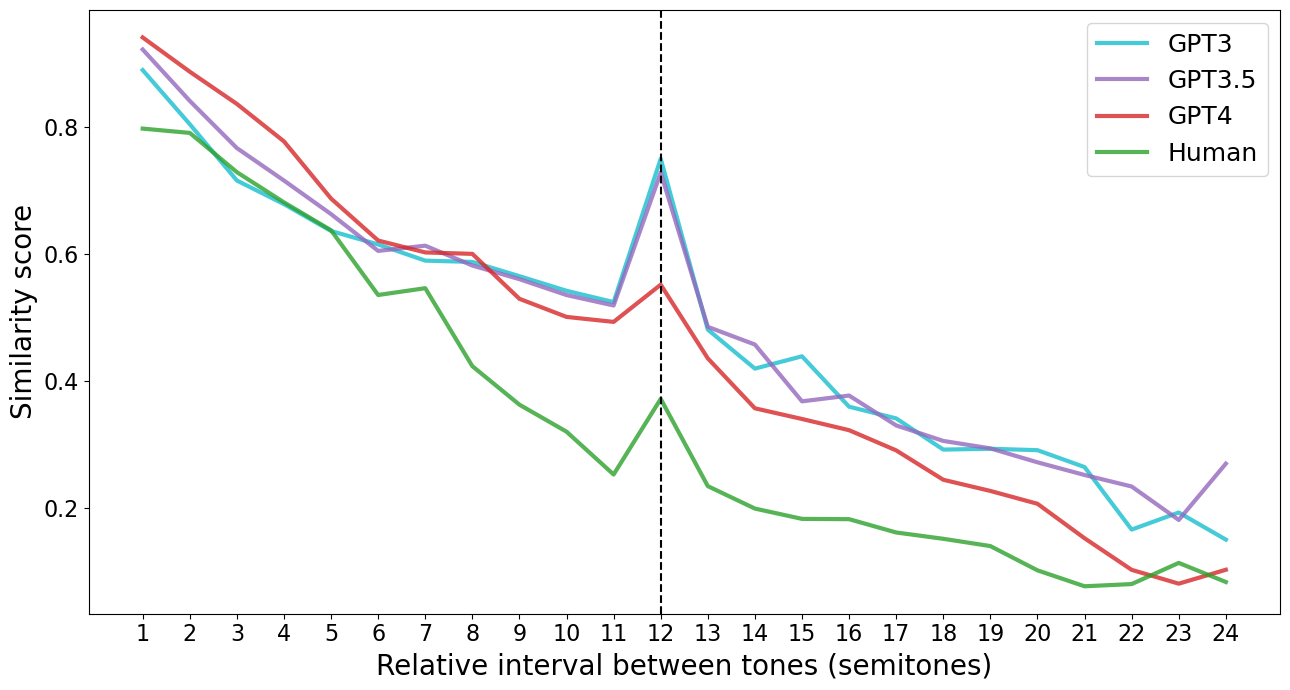

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (13, 7))
labels = [i for i in range(1, current_human_data.shape[0])]
ax.plot(labels, all_marginals_pitch["gpt3"], color = "tab:cyan", alpha = 0.8, label = "GPT3", linewidth=3)
ax.plot(labels, all_marginals_pitch["gpt35"], color = "tab:purple", alpha = 0.8, label = "GPT3.5", linewidth=3)
ax.plot(labels, all_marginals_pitch["gpt4"], color = "tab:red", alpha = 0.8, label = "GPT4", linewidth=3)
ax.plot(labels, compute_diagonal_marginals(all_human_data["pitch"]["similarity"]), color = "tab:green", alpha = 0.8, label = "Human", linewidth=3)
ax.axvline(x = 12, color = 'black', ls = "--")
# ax.plot(labels, compute_diagonal_marginals(current_human_data), color = "red", alpha = 0.8, label = "Human")
ax.set_xticks(labels);
ax.legend(fontsize = 18)
ax.set_xlabel("Relative interval between tones (semitones)", fontsize = 20)
ax.set_ylabel("Similarity score", fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
# plt.savefig("figures/all_pitch_marginals.pdf")

# Split-half reliability analysis

In [65]:
data_pitch = pd.read_csv("raw_data/pitch_similarity_non_musicians_simpitchv2_b3yr.csv")
data_pitch["idx_1"] = data_pitch["idx_1"] - 1
data_pitch["idx_2"] = data_pitch["idx_2"] - 1
data_cons = pd.read_csv("raw_data/individual_similarity_vocconsim.csv")
data_cons["idx_1"] = data_cons["stim_1_symbol_idx"]
data_cons["idx_2"] = data_cons["stim_2_symbol_idx"]

In [66]:
def compute_similarity(data, num_stim):
    processed = data[["idx_1","idx_2","participant_id","answer"]].copy()
    N = num_stim
    sim_mat = np.zeros(shape=(N,N))
    processed = processed.groupby(["idx_1","idx_2"],as_index=False).mean()
    for i in range(len(processed.index)):
        idx1 = processed["idx_1"][i]
        idx2 = processed["idx_2"][i]
        sim_mat[idx1, idx2] = processed["answer"][i]
    sim_mat = sim_mat + np.transpose(sim_mat)
    sim_mat = sim_mat / 6
    np.fill_diagonal(sim_mat, 1)
    return sim_mat
    

def create_split_half_matrices(data, num_stim, nboot=1000, random_state=1234):
    np.random.seed(random_state)
    processed_data = data.copy()
    
    data_boot_list_half_1 = []
    data_boot_list_half_2 = []
    matrix_boot_list_half_1 = []
    matrix_boot_list_half_2 = []
    
    for i in range(nboot):
        n_participants = len(np.unique(processed_data["participant_id"].to_numpy()))
        gb = processed_data.groupby('participant_id')    
        participant_split = [gb.get_group(x) for x in gb.groups]
        np.random.shuffle(participant_split)
        participant_split_1 = participant_split[0:(len(participant_split) // 2)]
        participant_split_2 = participant_split[(len(participant_split) // 2):]
        resampled_data_1 = pd.concat(participant_split_1, ignore_index=True)
        resampled_data_2 = pd.concat(participant_split_2, ignore_index=True)
        resampled_data_1 = resampled_data_1.assign(nboot = i)
        resampled_data_2 = resampled_data_2.assign(nboot = i)
        sim_mat_boot_1 = compute_similarity(resampled_data_1, num_stim)
        sim_mat_boot_2 = compute_similarity(resampled_data_2, num_stim)
        data_boot_list_half_1 = data_boot_list_half_1 + [resampled_data_1]
        data_boot_list_half_2 = data_boot_list_half_2 + [resampled_data_2]
        matrix_boot_list_half_1 = matrix_boot_list_half_1 + [sim_mat_boot_1]
        matrix_boot_list_half_2 = matrix_boot_list_half_2 + [sim_mat_boot_2]

    data_boots_half_1 = pd.concat(data_boot_list_half_1, ignore_index=True)
    data_boots_half_2 = pd.concat(data_boot_list_half_2, ignore_index=True)
    
    return data_boots_half_1, data_boots_half_2, matrix_boot_list_half_1, matrix_boot_list_half_2

# test1, _, simmat1, simmat2 = create_split_half_matrices(10, data, list_of_chords)

def run_split_half_analysis(simmat_h1_list, simmat_h2_list):
    rdd_list = [] # data data
    for i in range(len(simmat_h1_list)):
        vd1 = squareform(1 - simmat_h1_list[i])
        vd2 = squareform(1 - simmat_h2_list[i])
        rdd = np.corrcoef(vd1, vd2)[0][1]
        rdd_list.append(rdd)
    return rdd_list

In [67]:
_, _, sim1, sim2 = create_split_half_matrices(data_pitch, 25)

In [68]:
rdd_list_pitch = run_split_half_analysis(sim1, sim2)

In [69]:
print("Pitch")
print("Split-half inter-rater reliability")
print(f"Mean IRR {np.mean(rdd_list_pitch)}")
print(f"LCI {np.mean(rdd_list_pitch) - 1.96 * np.std(rdd_list_pitch)}")
print(f"UCI {np.mean(rdd_list_pitch) + 1.96 * np.std(rdd_list_pitch)}")

Pitch
Split-half inter-rater reliability
Mean IRR 0.903807339626984
LCI 0.886936697223294
UCI 0.920677982030674


In [70]:
_, _, sim1, sim2 = create_split_half_matrices(data_cons, 16)

In [71]:
rdd_list_cons = run_split_half_analysis(sim1, sim2)

In [72]:
print("Consonants")
print("Split-half inter-rater reliability")
print(f"Mean IRR {np.mean(rdd_list_cons)}")
print(f"LCI {np.mean(rdd_list_cons) - 1.96 * np.std(rdd_list_cons)}")
print(f"UCI {np.mean(rdd_list_cons) + 1.96 * np.std(rdd_list_cons)}")

Consonants
Split-half inter-rater reliability
Mean IRR 0.4596712391413537
LCI 0.3558379536605896
UCI 0.5635045246221178
